# Моделювання Кризових Явищ

## Передбачення фінансових криз

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Download stock market data (e.g., S&P 500 as a proxy for the overall market)
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')

print(sp500_data.head(10))
sp500_data['Return'] = sp500_data['Close'].pct_change()  # Calculate daily returns

# Download bond yield data (as an economic indicator)
bond_yield_data = yf.download('^TNX', start='2000-01-01', end='2023-01-01')  # 10-year Treasury yield
bond_yield_data['Yield'] = bond_yield_data['Close']

# Merge datasets by date
data = sp500_data[['Return']].merge(bond_yield_data[['Yield']], left_index=True, right_index=True)
data.dropna(inplace=True)  # Remove rows with missing values

sp500_data[:10]

C:\Users\vmelnyk2\AppData\Local\Temp\ipykernel_29844\3584615234.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\vmelnyk2\AppData\Local\Temp\ipykernel_29844\3584615234.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bond_yield_data = yf.download('^TNX', start='2000-01-01', end='2023-01-01')  # 10-year Treasury yield


Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000
2000-01-10  1457.599976  1464.359985  1441.469971  1441.469971  1064800000
2000-01-11  1438.560059  1458.660034  1434.420044  1457.599976  1014000000
2000-01-12  1432.250000  1442.599976  1427.079956  1438.560059   974600000
2000-01-13  1449.680054  1454.199951  1432.250000  1432.250000  1030400000
2000-01-14  1465.150024  1473.000000  1449.680054  1449.680054  1085900000


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000,NaN
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.038345
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001922
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000956
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.027090
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011190
2000-01-11,1438.560059,1458.660034,1434.420044,1457.599976,1014000000,-0.013063
2000-01-12,1432.250000,1442.599976,1427.079956,1438.560059,974600000,-0.004386


Нам потрібно визначити, що таке фінансова криза. Загальноприйнятий підхід полягає у виділенні періодів екстремального спаду на ринку, коли прибутковість фондового ринку значно падає за короткий проміжок часу.

Crisis
0    5761
1      19
Name: count, dtype: int64


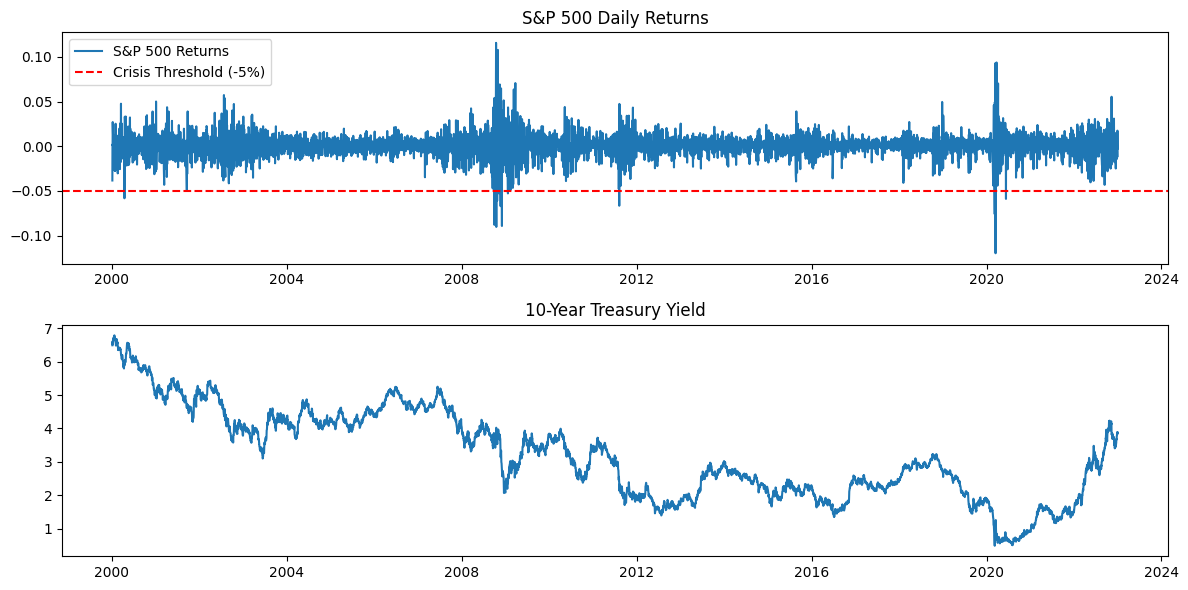

In [2]:
# Define a crisis if the return drops below a certain threshold (e.g., -5% in one day)
data['Crisis'] = (data['Return'] < -0.05).astype(int)

# Check the distribution of crisis events
print(data['Crisis'].value_counts())

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Return'], label='S&P 500 Returns')
plt.axhline(y=-0.05, color='r', linestyle='--', label='Crisis Threshold (-5%)')
plt.legend()
plt.title('S&P 500 Daily Returns')

plt.subplot(2, 1, 2)
plt.plot(data.index, data['Yield'], label='10-Year Treasury Yield')
plt.title('10-Year Treasury Yield')
plt.tight_layout()
plt.show()

Ми розділимо дані на навчальні та тестові набори, щоб оцінити ефективність нашої моделі.

In [3]:
# Define features (economic indicators) and target (Crisis label)
X = data[['Return', 'Yield']]
y = data['Crisis']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Ми будемо використовувати RandomForestClassifier для моделювання взаємозв'язку між економічними показниками та кризовими подіями.

In [4]:
# Build a Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Після навчання моделі ми оцінюємо її ефективність за допомогою матриці плутанини та звіту про класифікацію.

[[1151    0]
 [   0    5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1151
           1       1.00      1.00      1.00         5

    accuracy                           1.00      1156
   macro avg       1.00      1.00      1.00      1156
weighted avg       1.00      1.00      1.00      1156



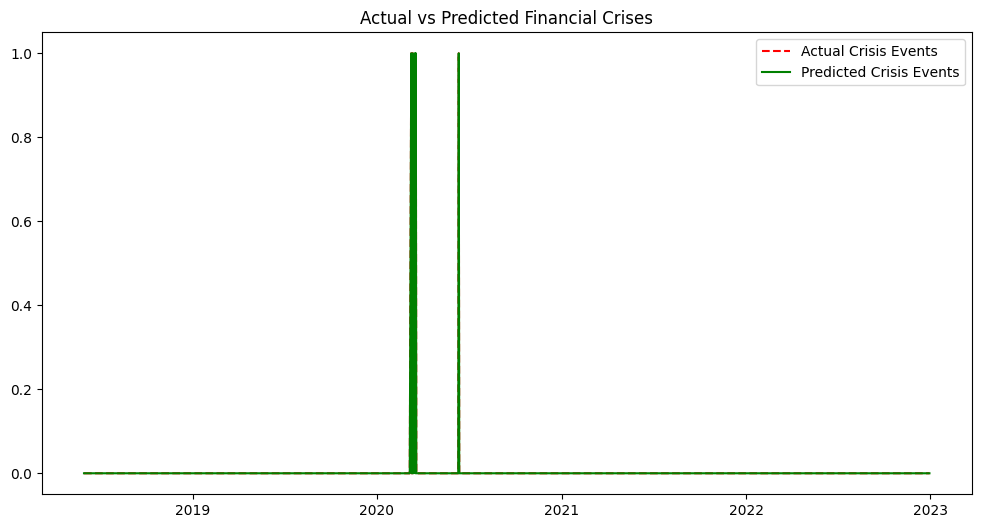

In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Display confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the predicted vs actual crises
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Crisis Events', color='r', linestyle='--')
plt.plot(y_test.index, y_pred, label='Predicted Crisis Events', color='g')
plt.title('Actual vs Predicted Financial Crises')
plt.legend()
plt.show()

## Моделювання розповсюдження епідемій

**SIR-модель** — це одна з найвідоміших математичних моделей для опису поширення інфекційних захворювань у популяції. Вона дозволяє зрозуміти, як хвороба поширюється, коли досягає піку та за яких умов епідемія згасає.

Модель була запропонована Кермаком та МакКендріком у 1927 році і досі є основою епідеміологічного моделювання.

SIR — це абревіатура від трьох станів, у яких може знаходитися кожна людина в популяції:

- S (Susceptible) — сприйнятливі: Люди, які ще не хворіють, але можуть заразитися.

- I (Infectious) — інфіковані:    Люди, які хворіють і здатні передавати інфекцію іншим.

- R (Recovered/Removed) — одужалі (або видалені): Люди, які або одужали й отримали імунітет, або були ізольовані, або померли (тобто не взаємодіють із іншими).

Популяція вважається закритою, тобто:

$$
N = S(t) + I(t) + R(t) = const
$$

Система диференціальних рівнянь: SIR-модель описується трьома рівняннями:

$$
\frac{dS(t)}{dt} = -\beta \frac{S(t) *I(t)}{N}
$$

$$
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I
$$

$$
\frac{dR}{dt} = \gamma I
$$

- β (бета) - коефіцієнт інфікування - показує, як часто відбуваються контакти та з якою ймовірністю вони ведуть до зараження.

- γ (гама) - коефіцієнт одужання - це швидкість переходу з I → R. Якщо середня тривалість хвороби — $D$ днів, то:
  $$
  \gamma \approx \frac{1}{D}
  $$

Базове репродуктивне число $R_0$ - найважливіший параметр епідемії:

$$
R_0 = \frac{\beta}{\gamma}
$$

- Якщо $R_0 > 1$ — хвороба поширюється → епідемія.
- Якщо $R_0 < 1$ — хвороба згасає.

Інтуїтивно це означає, скільки людей у середньому заразить один хворий у незахищеній популяції.


Динаміка епідемії: типовий перебіг для SIR:

- На початку багато S та мало I → інфекція швидко росте.
- Максимальне значення I, потім спадає
- З часом S зменшується, тому інфікування сповільнюється.
- Коли кількість сприйнятливих падає нижче певного порогу, хвиля епідемії природно згасає.
- Збільшується група R — тих, хто набув імунітету.

Інтерпретація кривих: на графіку зазвичай видно:

- S(t) плавно зменшується.
- I(t) різко зростає, досягає піку, потім спадає.
- R(t) зростає та стабілізується.

Пік I(t) залежить від параметрів β та γ — і саме його намагаються "сплющити" карантинними заходами.

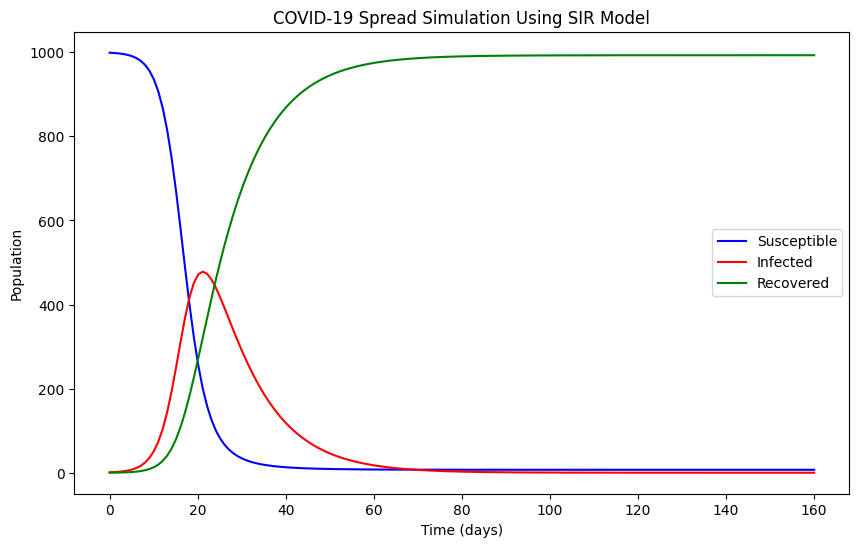

In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters for the SIR model
N = 1000         # Total population
I0 = 1           # Initial number of infected individuals
R0 = 0           # Initial number of recovered individuals
S0 = N - I0 - R0 # Initial number of susceptible individuals
beta = 0.5     # Infection rate
gamma = 0.1      # Recovery rate

# Time points (days)
t = np.linspace(0, 160, 160)

# SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t
ret = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('COVID-19 Spread Simulation Using SIR Model')
plt.legend()
plt.show()